In [1]:
import requests
import os
import re
import random
import urllib.request

url_dict = {
    'shakespeare.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/shakespeare.txt',
    'spenser.txt': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/spenser.txt',
    'syllable_dict.txt' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/Syllable_dictionary.txt',
    'about_syllable_dict.docx' : 'https://caltech-cs155.s3.us-east-2.amazonaws.com/miniprojects/project3/data/syllable_dict_explanation.docx'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('shakespeare.txt')
download_file('spenser.txt')
download_file('syllable_dict.txt')
# download_file('about_syllable_dict.docx')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [2]:
import string
import torch
import numpy as np

shakespeare = open("shakespeare.txt", "r").read()
chars = set(shakespeare)
for i in range(0, 10):
    chars.remove(str(i))
chars = list(chars)
num_chars = len(chars)

def letterToIndex(letter):
    return chars.index(letter)

def charToTensor(char):
    tensor = torch.zeros(1, num_chars)
    tensor[0][letterToIndex(char)] = 1
    return tensor

def stringToTensor(line):
    tensor = torch.zeros(len(line), 1, num_chars)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

# Get a list of poem strings
def get_poems(txt_file):
    with open(txt_file, 'r') as file:
        text = file.read()
        poem_pattern = r'\s*(\d+)\s*(.*?)\s*(?=^\s*\d+|\Z)'  # chatGPT
        poem_matches = re.findall(poem_pattern, text, re.DOTALL | re.MULTILINE)
        poems = []
        for match in poem_matches:
            poems.append(match[1].strip())
        return poems

# get all training sequences from poem list
def get_training_seqs(poems, seq_length, jump=1): # jump > 1 gives semi-redundant sequences
    seqs = []
    for poem in poems:
        for i in range(0, len(poem), jump):
            seq = poem[i:(i + seq_length)]
            if len(seq) == seq_length:
                seqs.append(seq)
    return seqs

In [3]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        lstm_out, next_hidden = self.lstm(input, hidden)
        out = self.output(lstm_out)
        return out, next_hidden

    def initHidden(self):
        return (torch.zeros(1, self.hidden_size), torch.zeros(1, self.hidden_size))
    
n_hidden = 150
rnn = LSTM(num_chars, n_hidden, num_chars)

In [4]:
poems = get_poems("shakespeare.txt")
seqs = get_training_seqs(poems, 40 + 1, 5)

print(len(seqs))
# print(seqs)
print(len(seqs[0]))


17652
41


In [5]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.005

def train(target_tensor, seq_tensor): # a tensor encoding of sequence and a tensor encoding of target
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0
    for i in range(seq_tensor.size()[0]):
        output, hidden = rnn(seq_tensor[i], hidden)
        loss += criterion(output, target_tensor[i])

    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()/(seq_tensor.size()[0])

In [6]:
def get_training_examples(seqs):
    training_examples = []
    for i in range(len(seqs)):
        seq = seqs[i]
        training_examples.append([stringToTensor(seq[1:]), stringToTensor(seq[:-1])])

    return training_examples

In [7]:
e = get_training_examples(seqs)
len(e[0][1])

40

In [9]:
e[0][1].shape

torch.Size([40, 1, 61])

In [10]:
n_epochs = 10
plot_every = 500
all_losses = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

for iter in range(n_epochs):
    training_examples = get_training_examples(seqs)
    indices = np.random.permutation(len(training_examples))
    for i in range(len(indices)):
        output, loss = train(training_examples[indices[i]][0], training_examples[indices[i]][1])
        total_loss += loss

        if i % plot_every == 0:
            if i != 0:
                all_losses.append(total_loss / plot_every)
                print("Loss: " + str(total_loss / plot_every))
            total_loss = 0
            

Loss: 0.008226568603515625
Loss: 3.181970743179321
Loss: 3.0148144989013668
Loss: 2.8053440269470236
Loss: 2.6132248996734635
Loss: 2.4899052268981943
Loss: 2.3961157188415534
Loss: 2.311085726928711
Loss: 2.2707682193756122
Loss: 2.2231869651794423
Loss: 2.1882022487640382
Loss: 2.1621800683975225
Loss: 2.1213879230499257
Loss: 2.0749089136123637
Loss: 2.0679728639602626
Loss: 2.040714266967773
Loss: 2.0125564439773567
Loss: 2.0062155115127567
Loss: 1.987803317642215
Loss: 1.9746214067459102
Loss: 1.9486514310836782
Loss: 1.9550913038253777
Loss: 1.9211914752960213
Loss: 1.9208124418258683
Loss: 1.9114261880874643
Loss: 1.9014779249191287
Loss: 1.8960441070556644
Loss: 1.8636450302124017
Loss: 1.8715417619705206
Loss: 1.8633321159362801
Loss: 1.8625236143112185
Loss: 1.8343182323455804
Loss: 1.8324523113250746
Loss: 1.813181274986267
Loss: 1.7976452125549307
Loss: 1.8154640186309823
Loss: 0.5495320169448851
Loss: 1.7963130500793465
Loss: 1.7720404779434196
Loss: 1.7880356248855602
Los

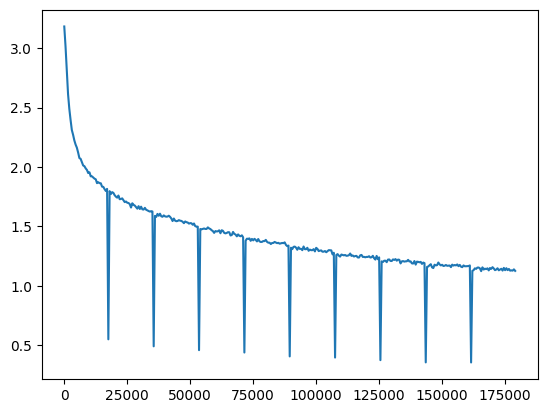

In [11]:
import matplotlib.pyplot as plt

plt.plot(plot_every * np.arange(len(all_losses) - 1), all_losses[1:])

In [14]:
# Sample from a category and starting letter
def sample(start_seed, temperature, num_additional_lines):
    with torch.no_grad():  # no need to track history in sampling
        input = stringToTensor(start_seed)
        hidden = rnn.initHidden()
        h = hidden
        line_num = 0

        output_poem = start_seed

        # use seed to set initial hidden values
        for i in range(len(start_seed) - 1):
            output, h = rnn(input[i], h)
            hidden = h

        while line_num < num_additional_lines:
            output, hidden = rnn(input[-1], hidden)
            output = output[-1] # just get the new character
            output = output / temperature
            s = nn.Softmax(dim=0)
            probs = s(output)
            letter = np.random.choice(chars, p=np.array(probs))
            output_poem += letter
            if letter == "\n":
                line_num += 1
            seq = output_poem[-40:]
            input = stringToTensor(seq)

        return output_poem

In [16]:
start_seed = "Shall I compare thee to a summer's day?\n"
output = sample(start_seed, 1, 13)
print(output)

Shall I compare thee to a summer's day?
Sometion those influest, and arty's partse they
You sicklise the beaut that right, nor ngelily expraish change dyalily,
Thou art as sun then tender strancelt mine of love doth show,
And himbance bounty allegaid do flame hich well hake,
Thy swool, or this injurious gener
I with thy thoughts, some had write what is eyed,
And proud to clartlatch that have retamenove, which my bud by nature's bring annins are puble change?
Be eye is lay I not by their deeds,
And constant sprition smadering made but ling,
  And most undes of things increase,
Within becoming one nutless the braak of truth,
So drinf I looked of single offen!
Ne ornatenty to the bad!en till,



In [17]:
start_seed = "Shall I compare thee to a summer's day?\n"
output = sample(start_seed, 0.75, 13)
print(output)

Shall I compare thee to a summer's day?
With mine, hows beauty being doth with digning fair
O hatch and therefore my fold dined in thy heart and truch my self to grace,
And then she hath my love, not fallse as thy love, with the drught to be,
And beauteous beauty slaves thy fair whose thou art, and his sweet self stol of five?
A tent thy subject spirit hue) of nature's use the fairs to monury by assuming smore,
And do not gave thereks from love thy shame thy self in great tone's spend,
By steal one is thine, any storm-tired frant a flower,
Whan since lencul to-day doth it assured from thy heart themsing homs:
  But hand, thou record of such a  beauty is so strong,
That thou art the dust not be sorrow it, see them live the sweet lovely priz,
To leave me dath do not unknow dead,
The one what strong spite of with a wantonly,
Which I my soberefif thy self to break will be writ Were but to the better spite



In [21]:
start_seed = "Shall I compare thee to a summer's day?\n"
output = sample(start_seed, 0.25, 13)
print(output)

Shall I compare thee to a summer's day?
With subjer that a face sweet love their stalled single and therefore,
  That every sweet self strong souned as and therefore to self arrishone,
When then my glass will the stars the day to hell eyes,
That thou art brief the diseased the stars to thee,
  That thou art all these content the distracted thee black will be the true,
They do I have sweet thee, thy sweet seen the breath the distont old,
To summeran glance apon thy soul's thou art as the world will be the tremory of words and strangelligge:
Then beauteous self thou art as the world's eye of your swift messest short,
Which I my love that tongue-tied to my but to the time's lender agion,
  Then of thy self arisht those that which shall have sometime,
Which shall to steal my silf his selled single him,
Why should my love the writery shall have sweet thy sweet self still me than give thee of the time,
And that thou grow'st is thou art as the world will be the tremory,

